### Домашнее задание <a class="anchor" id="hw"></a><center>

In [1]:
# Градиентный бустинг (AdaBoost) - это мощный алгоритм машинного обучения,
# который используется как для задач классификации, так и для регрессии.
# Он основан на идее построения композиции слабых моделей (например, деревьев решений),
# каждая из которых исправляет ошибки предыдущей модели.

# Основная идея AdaBoost заключается в том, чтобы последовательно
# обучать модели на взвешенных подмножествах данных,
# при этом веса неправильно классифицированных точек увеличиваются на каждой итерации.
# На каждом шаге новая модель "фокусируется" на тех объектах,
# которые предыдущая модель классифицировала неправильно.

# Одно из ключевых преимуществ градиентного бустинга - это его способность
# к адаптации к сложным структурам данных и высокая точность предсказаний.
# Однако важно учитывать, что градиентный бустинг может быть склонен к переобучению,
# особенно если количество базовых моделей слишком велико или если данные содержат шумы.

# Также стоит отметить, что существует несколько вариаций градиентного бустинга,
# таких как XGBoost, LightGBM и CatBoost, которые в разной степени
# оптимизируют производительность и обучение моделей.

In [2]:
# Импортирует модуль model_selection из библиотеки sklearn,
# который содержит различные инструменты для разделения данных
# на обучающие и тестовые наборы, а также для выполнения кросс-валидации.
from sklearn import model_selection

# Импортирует класс DecisionTreeRegressor из модуля tree в библиотеке sklearn.
# DecisionTreeRegressor - это модель регрессии, основанная на дереве решений,
# которая используется для построения дерева решений для решения задач регрессии.
from sklearn.tree import DecisionTreeRegressor

# Импортирует функцию load_diabetes из модуля datasets в sklearn.
# load_diabetes - это функция для загрузки набора данных о диабете,
# который часто используется в примерах машинного обучения
# для демонстрации различных методов обучения и оценки.
from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге, но уже оптимизированную (задание 3*).

In [5]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    # было
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )

    # стало
    predictions = np.array(
        sum([eta * alg.predict(X) for alg in trees_list])
    )
    
    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [8]:
# Объявление функции gb_fit, которая принимает следующие аргументы:
# n_trees: количество деревьев в градиентном бустинге,
# max_depth: максимальная глубина деревьев,
# X_train, X_test: признаки обучающего и тестового наборов данных,
# y_train, y_test: целевые переменные обучающего и тестового наборов данных,
# eta: скорость обучения (learning rate).
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    # Цикл для обучения заданного количества деревьев.
    for i in range(n_trees):

        # Создается экземпляр модели DecisionTreeRegressor с указанными параметрами,
        # включая максимальную глубину max_depth.
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        # Условие для первой итерации. Если список деревьев пуст,
        # то обучается первое дерево на всем обучающем наборе данных.
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            # Вычисление среднеквадратичной ошибки на обучающем и тестовом наборах данных
            # и добавление их в соответствующие списки.
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        # Если список деревьев не пустой
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            # Обучение нового дерева на ошибках предсказаний предыдущей композиции.
            tree.fit(X_train, residual(y_train, target))
            
            # Вычисление среднеквадратичной ошибки на обучающем и тестовом наборах данных
            # и добавление их в соответствующие списки.
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        # Добавление обученного дерева в список деревьев.
        trees.append(tree)

    # Возврат списка обученных деревьев и списков значений ошибок
    # на обучающем и тестовом наборах данных.   
    return trees, train_errors, test_errors

**1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

In [9]:
# Для отображения прогресса выполнения итераций в цикле.
from tqdm import tqdm

# Устанавливается значение скорости обучения (learning rate) равное 1.
eta = 1

# Создается диапазон значений глубины деревьев от 1 до 10 (не включая 11).
max_depths = range(1, 11)

# Объявление функции plot_different_max_depths, которая принимает два аргумента:
# n_trees: количество деревьев в градиентном бустинге (по умолчанию 3),
# max_depths: диапазон значений глубины деревьев (по умолчанию от 1 до 10).
def plot_different_max_depths(n_trees=3, max_depths=max_depths):

    # Создаются пустые списки для хранения значений ошибок
    # на обучающем и тестовом наборах данных для разных глубин деревьев.
    train_errors_depths = []
    test_errors_depths = []

    # Цикл для перебора всех значений глубины деревьев
    # из диапазона max_depths с отображением прогресса выполнения.
    for max_depth in tqdm(max_depths):

        # Вызывается функция gb_fit для обучения градиентного бустинга
        # с заданным количеством деревьев и глубиной деревьев.
        # Возвращаемые значения (списки значений ошибок на обучающем и тестовом наборах данных)
        # присваиваются переменным train_errors и test_errors.
        # Первое значение (_) игнорируется, так как оно не используется.
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

        # Значения последних ошибок на обучающем и тестовом наборах данных
        # добавляются в соответствующие списки.
        train_errors_depths.append(train_errors[-1])
        test_errors_depths.append(test_errors[-1])


    print(f'Количество деревьев в бустинге {n_trees}')

    # Строятся графики ошибок на обучающем и тестовом наборах данных
    # в зависимости от глубины деревьев.
    plt.plot(range(len(max_depths)), train_errors_depths, label='train_error')
    plt.plot(range(len(max_depths)), test_errors_depths, label='test_error')
    
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.legend()

100%|██████████| 10/10 [00:00<00:00, 61.35it/s]


Количество деревьев в бустинге 3


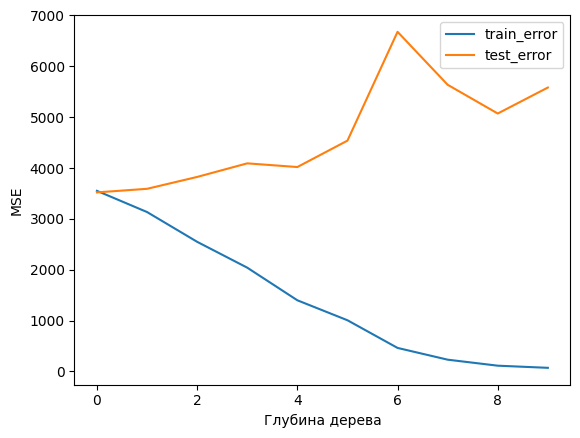

In [10]:
plot_different_max_depths(max_depths=max_depths, n_trees=3)

100%|██████████| 10/10 [00:00<00:00, 18.97it/s]


Количество деревьев в бустинге 10


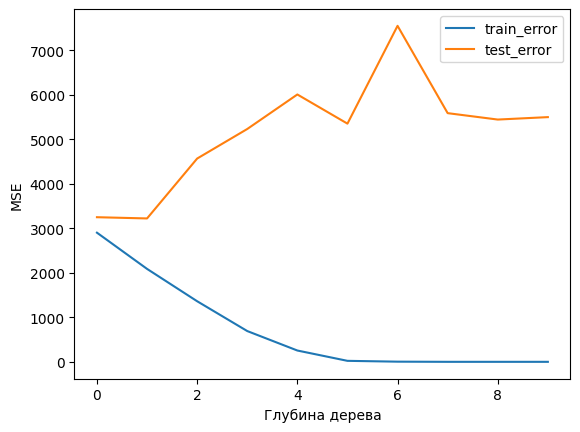

In [11]:
plot_different_max_depths(max_depths=max_depths, n_trees=10)

In [12]:
# Устанавливается значение скорости обучения (learning rate) равное 1.
eta = 1

# Создается диапазон значений количества деревьев
# в градиентном бустинге от 1 до 50 с шагом 1.
n_trees = range(1, 50, 1)

# Объявление функции plot_different_num_trees,
# которая принимает два аргумента по умолчанию:
# n_trees: диапазон значений количества деревьев
# в градиентном бустинге (по умолчанию от 1 до 50),
# max_depth: максимальная глубина деревьев (по умолчанию 3).
def plot_different_num_trees(n_trees=n_trees, max_depth=3):

    # Создаются пустые списки для хранения значений ошибок
    # на обучающем и тестовом наборах данных
    # для разного количества деревьев в бустинге.
    train_errors_trees = []
    test_errors_trees = []

    # Цикл для перебора всех значений количества деревьев
    # в градиентном бустинге с отображением прогресса выполнения.
    for n in tqdm(n_trees):

        # Вызывается функция gb_fit для обучения градиентного бустинга
        # с заданным количеством деревьев и максимальной глубиной.
        # Возвращаемые значения (списки значений ошибок на обучающем и тестовом наборах данных)
        # присваиваются переменным train_errors и test_errors.
        # Первое значение (_) игнорируется, так как оно не используется.
        _, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, eta)

        # Значения последних ошибок на обучающем и тестовом наборах данных
        # добавляются в соответствующие списки.
        train_errors_trees.append(train_errors[-1])
        test_errors_trees.append(test_errors[-1])


    print(f'Максимальная глубина дерева {max_depth}')

    # Строятся графики ошибок на обучающем и тестовом наборах данных
    # в зависимости от количества деревьев в градиентном бустинге.
    plt.plot(n_trees, train_errors_trees, label='train_error')
    plt.plot(n_trees, test_errors_trees, label='test_error')
    
    plt.xlabel('Количество алгоритмов в бустинге')
    plt.ylabel('MSE')
    plt.xticks(n_trees, n_trees)
    plt.legend()

100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


Максимальная глубина дерева 2


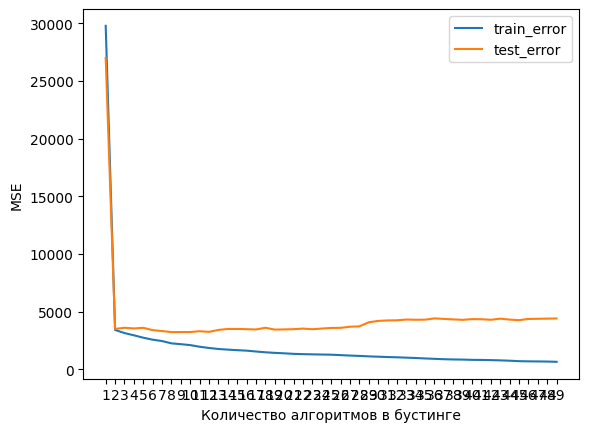

In [13]:
plot_different_num_trees(n_trees=n_trees, max_depth=2)

**2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

In [14]:
# Объявление функции sgb_fit, которая принимает следующие аргументы:
# n_trees: количество деревьев в градиентном бустинге,
# max_depth: максимальная глубина деревьев,
# X_train, X_test: признаки обучающего и тестового наборов данных,
# y_train, y_test: целевые переменные обучающего и тестового наборов данных,
# eta: скорость обучения (learning rate),
# sample_coef: коэффициент для определения размера подвыборки (по умолчанию 0.5).
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, sample_coef=0.5):

    # Получается количество образцов в обучающем наборе данных.
    n_samples = X_train.shape[0]

    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    # Цикл для обучения заданного количества деревьев.
    for i in range(n_trees):

        # Создается экземпляр модели DecisionTreeRegressor с указанными параметрами,
        # включая максимальную глубину max_depth.
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # Генерируются случайные индексы для создания подвыборки из обучающего набора данных.
        # Размер подвыборки определяется с использованием sample_coef.
        indices = np.random.randint(0, n_samples, int(n_samples * sample_coef))

        # Создаются подвыборка признаков и целевых переменных
        # с использованием сгенерированных случайных индексов.
        X_train_sampled, y_train_sampled = X_train[indices], y_train[indices]
        
        # первый алгоритм просто обучаем на выборке и добавляем в список
        # Если это первое дерево (len(trees) == 0),
        # то оно обучается на всем обучающем наборе данных.
        if len(trees) == 0:
            
            # обучаем первое дерево на случайной половине обучающей выборке            
            tree.fit(X_train_sampled, y_train_sampled)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        # Если это не первое дерево, то оно обучается на подвыборке обучающего набора данных
        # с использованием остатков предыдущих предсказаний.
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_sampled, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_sampled, residual(y_train_sampled, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
    
    # Возвращаются список обученных деревьев и списки значений ошибок
    # на обучающем и тестовом наборах данных.
    return trees, train_errors, test_errors

In [15]:
n_trees = 50
max_depth = 3
eta = 0.3

In [16]:
%%time
_, train_errors_gb, test_errors_gb = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: total: 734 ms
Wall time: 736 ms


In [17]:
%%time
_, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth,
                                               X_train, X_test,
                                               y_train, y_test,
                                               eta, 
                                               sample_coef=0.5
                                              )

CPU times: total: 703 ms
Wall time: 708 ms


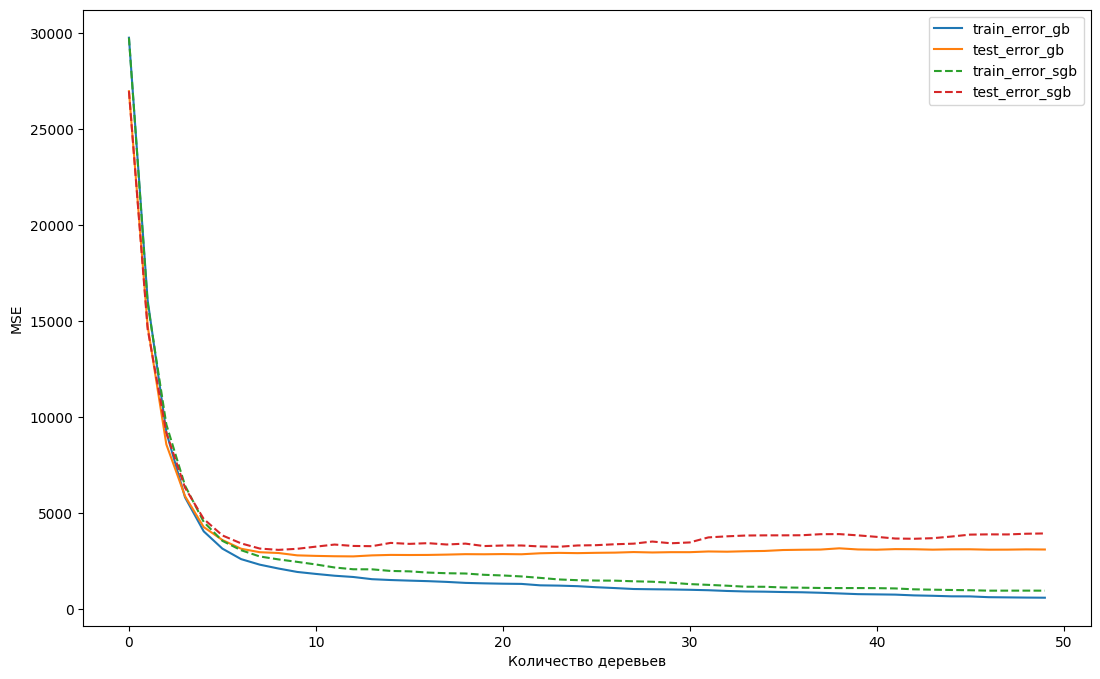

In [18]:
plt.figure(figsize=(13, 8))

# Рисует график значений ошибок на обучающем наборе данных для градиентного бустинга по оси x,
# где x - количество деревьев. train_errors_gb содержит значения ошибок на обучающем наборе данных
# для каждого количества деревьев. Параметр label указывает на то,
# что это линия графика будет помечена как 'train_error_gb'.
plt.plot(range(n_trees), train_errors_gb, label='train_error_gb')

# Рисует график значений ошибок на тестовом наборе данных для градиентного бустинга
# аналогично предыдущему пункту, но для тестового набора данных.
plt.plot(range(n_trees), test_errors_gb, label='test_error_gb')

# Рисует график значений ошибок на обучающем наборе данных для стохастического градиентного бустинга
# с пунктирной линией (linestyle='--'). Значения ошибок хранятся в train_errors_sgb.
plt.plot(range(n_trees), train_errors_sgb, label='train_error_sgb', linestyle='--')

# Рисует график значений ошибок на тестовом наборе данных для стохастического градиентного бустинга
# аналогично предыдущему пункту, но для тестового набора данных.
plt.plot(range(n_trees), test_errors_sgb, label='test_error_sgb', linestyle='--')

plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.legend();